<a href="https://colab.research.google.com/github/Wise-Wizard/RNN-IceCream-Production/blob/main/RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data


---



Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.


In [93]:
df = pd.read_csv("Frozen_Dessert_Production.csv", index_col="DATE", parse_dates=True)

In [94]:
df.columns = ["Production"]

In [95]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**TASK: Plot out the time series**

<Axes: xlabel='DATE'>

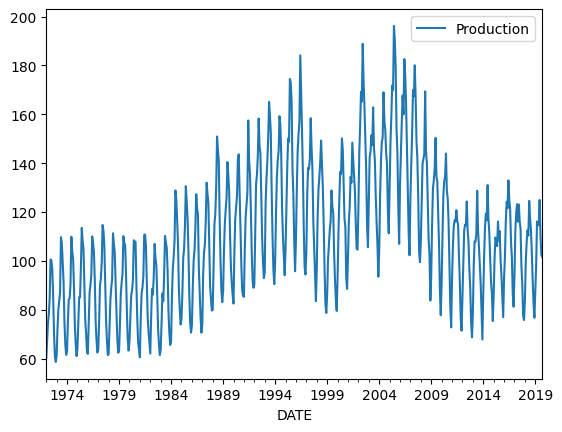

In [96]:
df.plot()

## Train Test Split

In [97]:
len(df)

573

In [98]:
split_len = len(df)-24

In [99]:
train_split = df.iloc[:split_len]
test_split = df.iloc[split_len:]


## Scale Data

In [100]:
from sklearn.preprocessing import StandardScaler

In [101]:
sc = StandardScaler()

In [102]:
scaled_train = sc.fit_transform(train_split)

In [103]:
scaled_test = sc.transform(test_split)

# Time Series Generator


In [104]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_features = 1
train_gen = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=24, batch_size=1)

### Create the Model



In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [106]:
model = Sequential()
model.add(LSTM(units=96, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [107]:
test_gen = TimeseriesGenerator(data=scaled_test, targets=scaled_test, length=23, batch_size=1)

In [108]:
from tensorflow.keras.callbacks import EarlyStopping

In [109]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

**Fit the model to the generator.**

In [110]:
model.fit_generator(generator=train_gen, epochs=6, validation_data= test_gen, callbacks=[early_stop])

<ipython-input-110-2f56354b5457>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_gen, epochs=6, validation_data= test_gen, callbacks=[early_stop])


Epoch 1/6
525/525 [==============================] - 12s 17ms/step - loss: 0.2693 - val_loss: 0.0053
Epoch 2/6
525/525 [==============================] - 8s 16ms/step - loss: 0.0804 - val_loss: 0.0175
Epoch 3/6
525/525 [==============================] - 7s 14ms/step - loss: 0.0666 - val_loss: 0.0575


**Plot the history of the loss that occured during training.**

<Axes: >

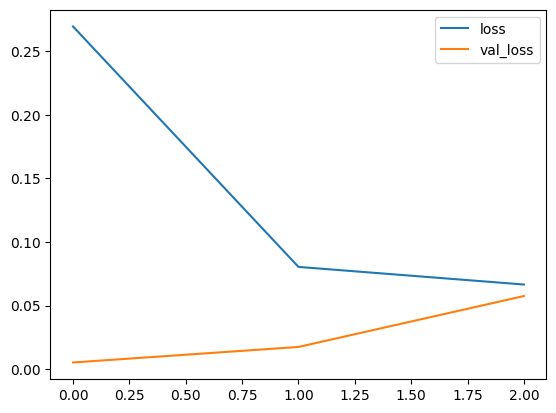

In [111]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

**TASK: Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [117]:
test_predictions = []

first_eval_batch = scaled_train[-24:]
current_batch = first_eval_batch.reshape((1, 24, n_features))

for i in range(24):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


In [119]:
true_predictions = sc.inverse_transform(test_predictions)

In [124]:
test_split['Predictions'] = true_predictions


<ipython-input-124-d1c23c70bf76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_split['Predictions'] = true_predictions


**Plot predictions versus the True test values.**

<Axes: xlabel='DATE'>

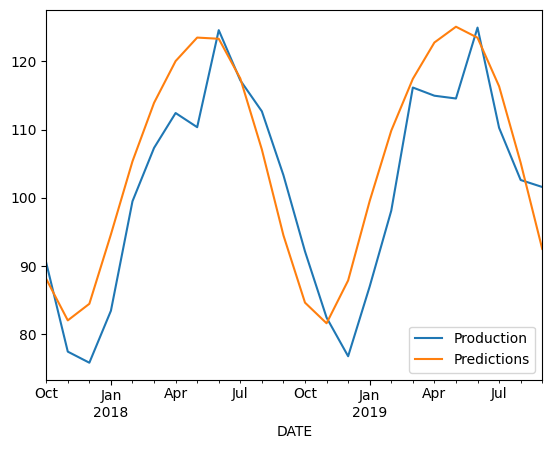

In [125]:
test_split.plot()

**TASK: Calculate your RMSE.**

In [126]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test_split['Production'],test_split['Predictions']))

7.700845086336436